# MI2 - ES04: Kernel Principal Component Analysis
## The chantastic 4: Elisabeth Kress, Paola Suárez, Jianmeng Wu and Esra Zihni

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy.linalg as LA
from sklearn.metrics.pairwise import euclidean_distances

## 1. Kernel PCA: Toy data set

### 1.a)  Create a toy data set

In [2]:
sd = 0.1
mus = np.array([[-0.5, -0.2], [0, 0.6], [0.5, 0]])
x = []
for i, mu in enumerate(mus):
    x.append(np.random.normal(mu, sd, (30,2)))
x = np.vstack(x)

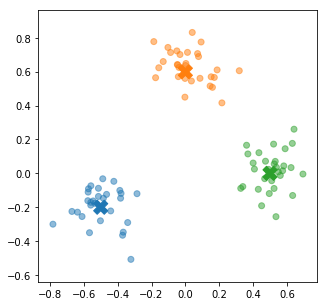

In [4]:
c = np.arange(90) // 30
colors = np.array(['C0', 'C1', 'C2'])
plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], marker='o', c=colors[c], alpha=0.5)
plt.scatter(mus[:,0], mus[:,1], marker='X', s=200, c=colors)
plt.axis('equal')
plt.show()

### 1.b) Apply a Kernel PCA

In [118]:
sigma = 0.1

def rbf_kernel(x, y, sigma=sigma):
    kernel = np.exp(-np.square(euclidean_distances(x, y))/(2*np.square(sigma)))
    return kernel

In [141]:
# calculate the kernel matrix
kernel = rbf_kernel(x, x)

# Center the Kernel
kernel_centered = kernel-kernel.mean(axis=0)-kernel.mean(axis=1)+kernel.mean()

# PCA
#cov = np.cov(kernel_centered.T)
l, w = LA.eig(kernel_centered/90) # eigenvectors in columns
l = l.real
w = w.real

# sort by eigenvalues
sortedIdx = np.flipud(np.argsort(l))
w = (w.T[sortedIdx]).T # eig in columns
l = l[sortedIdx]

# normalize the eigenvectors
w_n = np.array([w[:,i]/np.sqrt(90*l[i]) for i in range(90)])
w_n = w_n.T

# normalize the eigenvalues
l_n = l/l.sum()

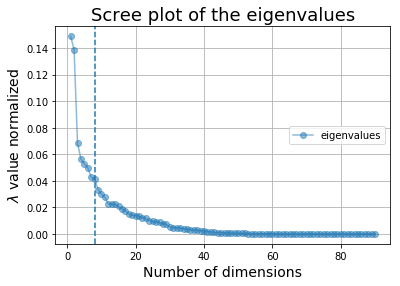

In [212]:
plt.figure()
plt.plot(np.arange(1,91), l_n, 'o-', label='eigenvalues', alpha=.5)
plt.axvline(x=8, linestyle='dashed')
#plt.plot(np.arange(1,91), np.cumsum(l_n), '.--', label='cumsum')
#plt.xlim(1, 8)
plt.title("Scree plot of the eigenvalues", size=18)
plt.xlabel("Number of dimensions", size=14)
plt.ylabel(r"$\lambda$ value normalized", size=14)
plt.legend(loc=7)
plt.grid()
plt.show()

### 1.c) Visualize the first 8 PCs

In [213]:
# create "query data" that is a meshgrid of the two dimensional input space
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
h = .005
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# predict the unseen data
# all points (px, py) on our grid in a nx2 matrix
query = np.c_[xx.ravel(), yy.ravel()]
k_query = rbf_kernel(query, x) # 29232x90
k_query_centered = ((k_query-k_query.mean(axis=0)).T-k_query.mean(axis=1)).T+k_query.mean()

# project onto the first 8 eigenvectors
w_p = w[:,:8]
Z = np.dot(w_p.T, k_query_centered.T)
Z = Z.reshape(8, xx.shape[0], xx.shape[1])

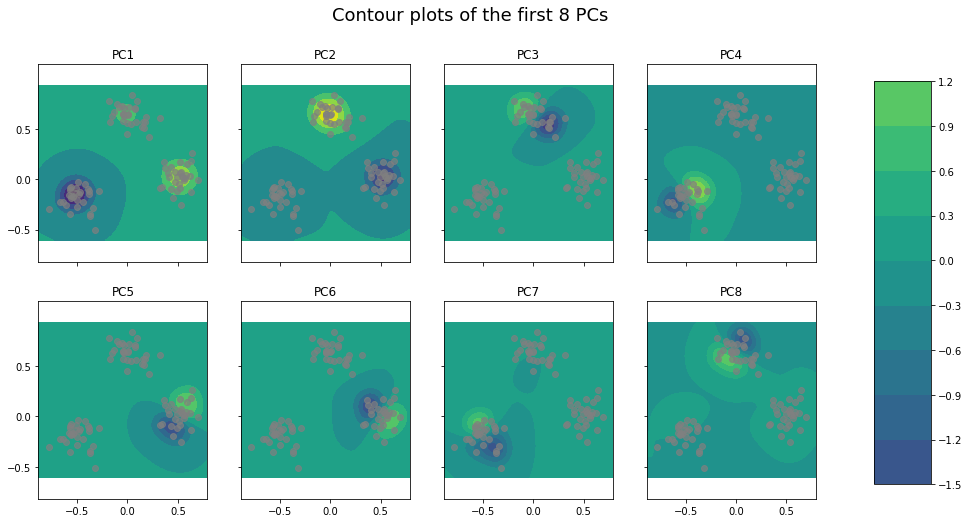

In [233]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):   
    im = ax.contourf(xx, yy, Z[i], vmin=Z.min(), vmax=Z.max())
    ax.scatter(x[:, 0], x[:, 1], c='Grey', alpha=.7)
    ax.axis('equal')
    ax.set_yticks([-.5, 0, .5])
    ax.set_title('PC%d'%(i+1))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Contour plots of the first 8 PCs', size=18)
plt.show()

- The computational cost of the kernel PCA grows enormously with increasing size of the dataset. For instance, the kernel matrix has the size of n² if we have n data points.
- It is hard to find the optimal sigma for the RBF-kernel. It would require a grid-search using cross-validation. This is computationally heavy.

### 1.d) Discussion